In [ ]:
# === CELL 1: Setup & Data Preparation ===
!pip install -q transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import f1_score

# 1. 绘图风格设置 (IEEE Standard)
plt.rcParams.update({
    'font.size': 12, 'font.family': 'serif',
    'axes.labelsize': 12, 'axes.titlesize': 14,
    'figure.figsize': (8, 6) # 单张图的大小
})

# 辅助函数: 计算 95% CI
def calc_ci(std, n=5):
    return 2.776 * (std / np.sqrt(n))

def plot_single_model(x_values, means, stds, xlabel, ylabel, title, filename, labels=None, x_scale='linear'):
    plt.figure()

    # 如果有多条线 (例如 SVM 的 Linear vs RBF)
    if isinstance(means, dict):
        for key in means.keys():
            yerr = [calc_ci(s) for s in stds[key]]
            # 不同的线用不同的 marker
            marker = 'o' if 'linear' in key.lower() or 'euclidean' in key.lower() else 's'
            plt.errorbar(x_values[key], means[key], yerr=yerr, label=key, marker=marker, capsize=5)
        plt.legend()
    # 如果只有一条线 (例如 BERT)
    else:
        yerr = [calc_ci(s) for s in stds]
        plt.errorbar(x_values, means, yerr=yerr, marker='D', color='purple', capsize=5)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if x_scale == 'log': plt.xscale('log')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    print(f"✅ 图表已保存为: {filename}")

# 2. 数据加载与划分
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    df = pd.read_csv('IMDB Dataset.csv')
except:
    !wget -q https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv
    !mv IMDB-Dataset.csv "IMDB Dataset.csv"
    df = pd.read_csv('IMDB Dataset.csv')

df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
X = df['review'].values; y = df['sentiment'].values

# Data Splitting (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42, stratify=y_temp)

print(f"Ready! Train: {len(X_train)}, Val: {len(X_val)}")
N_TRIALS = 5

Using device: cuda
Ready! Train: 40000, Val: 5000


--- Generating TF-IDF ---
--- Running Naive Bayes ---
Alpha: 0.1 | Acc: 0.8494 | F1: 0.8487
Alpha: 0.5 | Acc: 0.8490 | F1: 0.8482
Alpha: 1.0 | Acc: 0.8494 | F1: 0.8483
Alpha: 2.0 | Acc: 0.8504 | F1: 0.8491
Alpha: 5.0 | Acc: 0.8514 | F1: 0.8495
Alpha: 10.0 | Acc: 0.8514 | F1: 0.8483


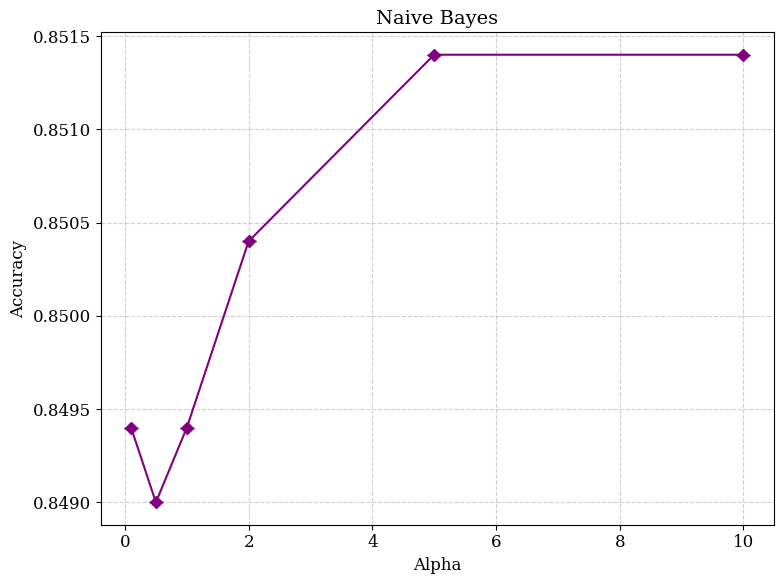

✅ 图表已保存为: nb_results.pdf


In [ ]:
# === CELL 2: Naive Bayes (Updated with F1) ===
from sklearn.metrics import f1_score

print("--- Generating TF-IDF ---")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("--- Running Naive Bayes ---")
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
# 这里的字典用来存最终结果，方便后面生成表格
nb_results = []

for alpha in alphas:
    trial_accs = []
    trial_f1s = [] # 新增：存 F1
    for _ in range(N_TRIALS):
        nb = MultinomialNB(alpha=alpha)
        nb.fit(X_train_tfidf, y_train)
        preds = nb.predict(X_val_tfidf)
        trial_accs.append(accuracy_score(y_val, preds))
        trial_f1s.append(f1_score(y_val, preds)) # 计算 F1

    mean_acc, std_acc = np.mean(trial_accs), np.std(trial_accs)
    mean_f1, std_f1 = np.mean(trial_f1s), np.std(trial_f1s)

    nb_results.append({'alpha': alpha, 'mean_acc': mean_acc, 'std_acc': std_acc, 'mean_f1': mean_f1, 'std_f1': std_f1})
    print(f"Alpha: {alpha} | Acc: {mean_acc:.4f} | F1: {mean_f1:.4f}")

# 画图还是画 Accuracy (通常图画 Acc，表列 F1)
plot_single_model(alphas, [r['mean_acc'] for r in nb_results], [r['std_acc'] for r in nb_results],
                  'Alpha', 'Accuracy', 'Naive Bayes', 'nb_results.pdf', x_scale='linear')

--- Running kNN ---
euclidean k=1: Acc=0.6934, F1=0.7042
euclidean k=3: Acc=0.7172, F1=0.7289
euclidean k=5: Acc=0.7270, F1=0.7372
euclidean k=10: Acc=0.7428, F1=0.7311
euclidean k=15: Acc=0.7472, F1=0.7472
euclidean k=25: Acc=0.7572, F1=0.7523
euclidean k=50: Acc=0.7656, F1=0.7506


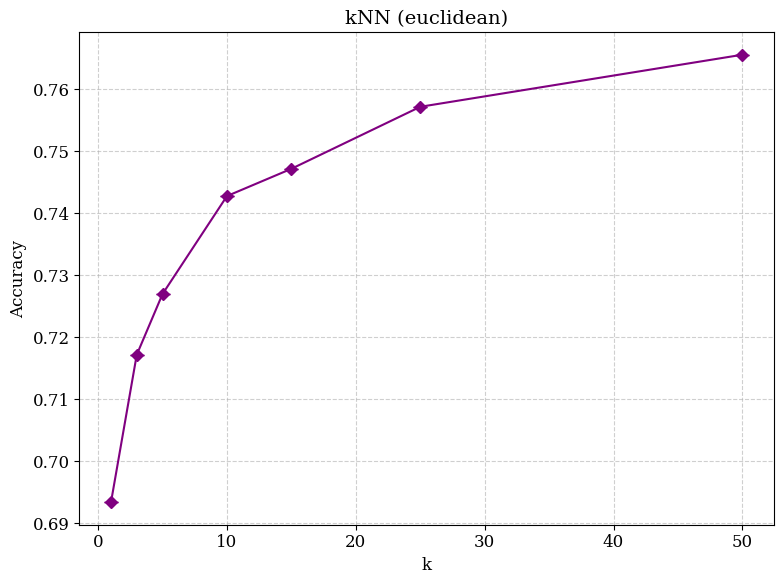

✅ 图表已保存为: knn_euclidean.pdf
cosine k=1: Acc=0.6934, F1=0.7042
cosine k=3: Acc=0.7172, F1=0.7289
cosine k=5: Acc=0.7270, F1=0.7372
cosine k=10: Acc=0.7428, F1=0.7311
cosine k=15: Acc=0.7472, F1=0.7472
cosine k=25: Acc=0.7572, F1=0.7523
cosine k=50: Acc=0.7656, F1=0.7506


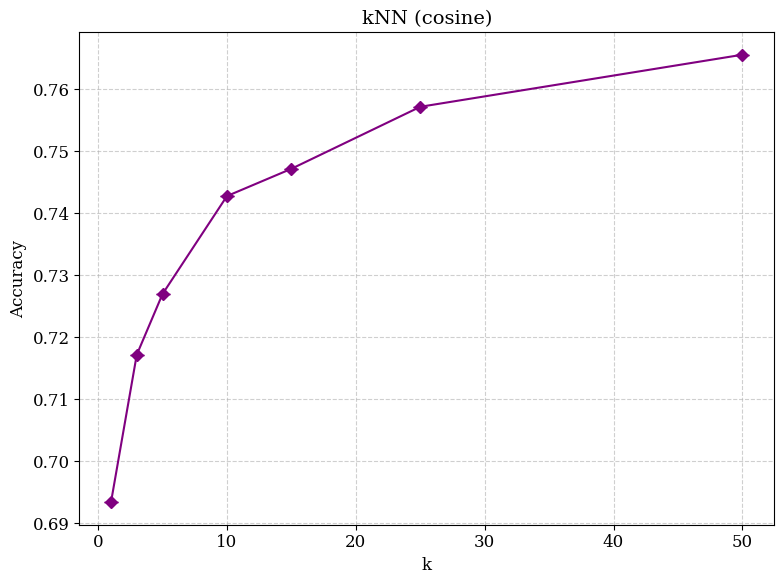

✅ 图表已保存为: knn_cosine.pdf


In [ ]:
# === CELL 3: kNN (Updated with F1) ===
k_values = [1, 3, 5, 10, 15, 25, 50]
metrics = ['euclidean', 'cosine']
knn_results = {} # 结构: knn_results[metric][k] = {mean_acc, mean_f1...}

print("--- Running kNN ---")
for metric in metrics:
    knn_results[metric] = []
    # 用于绘图的临时列表
    plot_means = []; plot_stds = []

    for k in k_values:
        trial_accs = []; trial_f1s = []
        for t in range(N_TRIALS):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
            knn.fit(X_train_tfidf, y_train)
            preds = knn.predict(X_val_tfidf)
            trial_accs.append(accuracy_score(y_val, preds))
            trial_f1s.append(f1_score(y_val, preds))

        m_acc, s_acc = np.mean(trial_accs), np.std(trial_accs)
        m_f1, s_f1 = np.mean(trial_f1s), np.std(trial_f1s)

        knn_results[metric].append({'k': k, 'mean_acc': m_acc, 'std_acc': s_acc, 'mean_f1': m_f1, 'std_f1': s_f1})
        plot_means.append(m_acc); plot_stds.append(s_acc)
        print(f"{metric} k={k}: Acc={m_acc:.4f}, F1={m_f1:.4f}")

    # 画图
    plot_single_model(k_values, plot_means, plot_stds, 'k', 'Accuracy', f'kNN ({metric})', f'knn_{metric}.pdf')

--- Running SVM ---
Testing linear C=0.01... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.7076 F1: 0.7711
Testing linear C=0.1... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.7872 F1: 0.8176
Testing linear C=1... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.8020 F1: 0.8096
Testing linear C=10... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.7470 F1: 0.7443
Testing linear C=50... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.7490 F1: 0.7454
Testing linear C=100... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.7490 F1: 0.7454


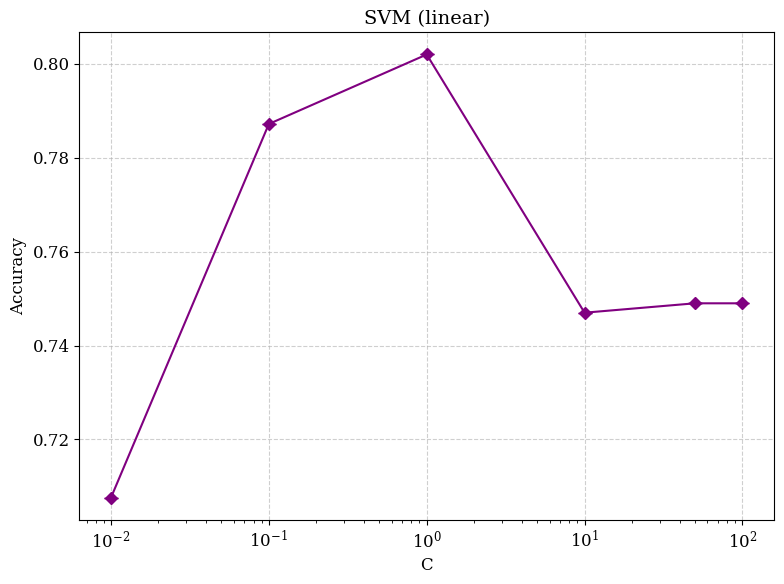

✅ 图表已保存为: svm_linear.pdf
Testing rbf C=0.01... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.7212 F1: 0.7795
Testing rbf C=0.1... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.8082 F1: 0.8318
Testing rbf C=1... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.8156 F1: 0.8148
Testing rbf C=10... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.8158 F1: 0.8127
Testing rbf C=50... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.8158 F1: 0.8127
Testing rbf C=100... 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Acc: 0.8158 F1: 0.8127


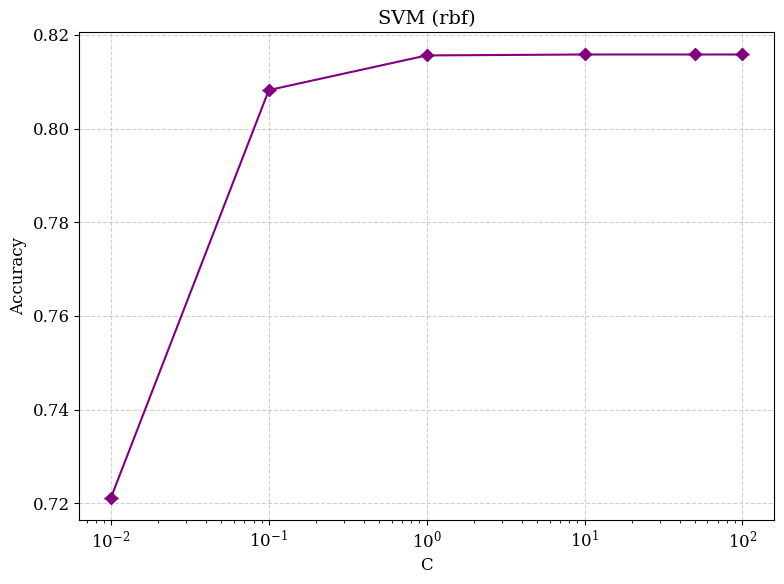

✅ 图表已保存为: svm_rbf.pdf


In [ ]:
# === CELL 4: SVM (Updated with F1) ===
kernels = ['linear', 'rbf']
C_values = [0.01, 0.1, 1, 10, 50, 100]
svm_results = {}

print("--- Running SVM ---")
for kernel in kernels:
    svm_results[kernel] = []
    plot_means = []; plot_stds = []

    for C in C_values:
        trial_accs = []; trial_f1s = []
        print(f"Testing {kernel} C={C}...", end=" ")
        for t in range(N_TRIALS):
            svm = SVC(kernel=kernel, C=C, gamma='scale', max_iter=2000)
            svm.fit(X_train_tfidf, y_train)
            preds = svm.predict(X_val_tfidf)
            trial_accs.append(accuracy_score(y_val, preds))
            trial_f1s.append(f1_score(y_val, preds))

        m_acc, s_acc = np.mean(trial_accs), np.std(trial_accs)
        m_f1, s_f1 = np.mean(trial_f1s), np.std(trial_f1s)

        svm_results[kernel].append({'C': C, 'mean_acc': m_acc, 'std_acc': s_acc, 'mean_f1': m_f1, 'std_f1': s_f1})
        plot_means.append(m_acc); plot_stds.append(s_acc)
        print(f"Acc: {m_acc:.4f} F1: {m_f1:.4f}")

    # 画图 (Accuracy)
    plot_single_model(C_values, plot_means, plot_stds, 'C', 'Accuracy', f'SVM ({kernel})', f'svm_{kernel}.pdf', x_scale='log')

1. Building Vocabulary & Tokenizing for LSTM...
   Encoding text to sequences...
   Data ready! Input shape: (40000, 200)

2. Running LSTM Experiments (This takes time)...

--- Testing Dropout Rate: 0.2 ---
Hidden=64... ..... -> Acc: 0.8335 | F1: 0.8320
Hidden=128... ..... -> Acc: 0.8557 | F1: 0.8549
Hidden=256... ..... -> Acc: 0.8548 | F1: 0.8521

--- Testing Dropout Rate: 0.5 ---
Hidden=64... ..... -> Acc: 0.7961 | F1: 0.7909
Hidden=128... ..... -> Acc: 0.8548 | F1: 0.8540
Hidden=256... ..... -> Acc: 0.8580 | F1: 0.8575

3. Plotting Results...


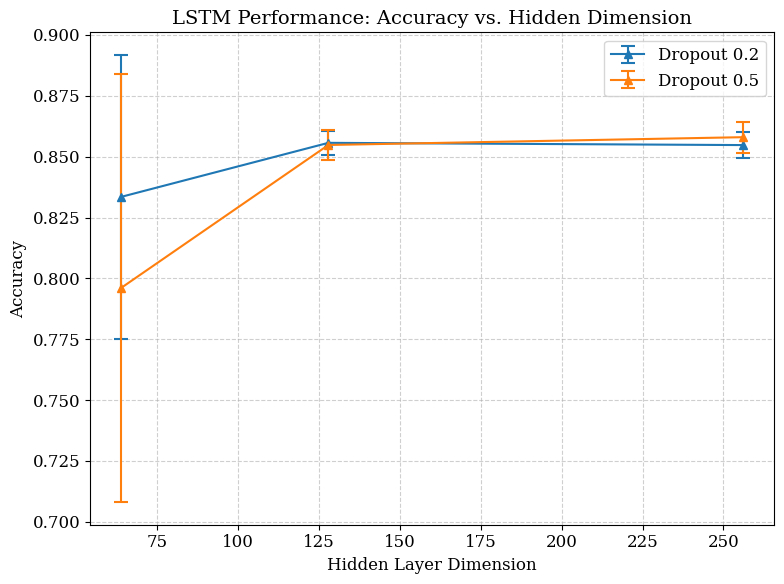

✅ LSTM 图表已保存为: lstm_results.pdf


In [ ]:
# === CELL 5: LSTM (Data Prep + Training + Plotting) ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# --- A. 数据准备 (Data Preparation specific for LSTM) ---
print("1. Building Vocabulary & Tokenizing for LSTM...")

# 1. 定义 Tokenizer 函数
def tokenize_lstm(text_list, vocab_map, max_len=200):
    encoded = []
    for text in text_list:
        tokens = text.lower().split()
        # 将单词转为数字，如果不在词表里就用 1 (<UNK>)
        vec = [vocab_map.get(w, 1) for w in tokens]

        # Padding (补0) 或 Truncating (截断)
        if len(vec) < max_len:
            vec = vec + [0] * (max_len - len(vec))
        else:
            vec = vec[:max_len]
        encoded.append(vec)
    return np.array(encoded)

# 2. 建立词表 (只用训练集!)
all_words = []
for r in X_train:
    all_words.extend(r.lower().split())

counts = Counter(all_words)
# 只保留最常出现的 5000 个词
vocab = sorted(counts, key=counts.get, reverse=True)[:5000]

# 创建映射字典
word_to_int = {w: i+2 for i, w in enumerate(vocab)}
word_to_int['<PAD>'] = 0  # 0 用于补位
word_to_int['<UNK>'] = 1  # 1 用于未知词

# 3. 转换数据
print("   Encoding text to sequences...")
X_train_seq = tokenize_lstm(X_train, word_to_int)
X_val_seq = tokenize_lstm(X_val, word_to_int)

# 4. 创建 PyTorch DataLoaders
# 将 numpy 数组转为 Tensor
train_data = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val_seq), torch.from_numpy(y_val))

# Batch Size 固定为 32 (根据你的论文描述)
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
val_loader = DataLoader(val_data, shuffle=False, batch_size=32)

print("   Data ready! Input shape:", X_train_seq.shape)


# --- B. 模型定义 (Model Definition) ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # batch_first=True: 输入格式为 (batch, seq, feature)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1) # 输出一个 Logit

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embeds)
        # 取最后一个时间步的 hidden state
        final_hidden = hidden[-1]
        out = self.dropout(final_hidden)
        out = self.fc(out)
        return out

# --- C. 训练函数 (Training Loop with F1) ---
def train_lstm(hidden_dim, dropout_rate):
    # 初始化模型
    model = LSTMClassifier(len(word_to_int), 100, hidden_dim, dropout_rate)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    best_acc = 0
    best_f1 = 0
    patience = 3 # Early Stopping 耐心值
    counter = 0

    # 最多跑 15 Epochs (通常 5-8 个就收敛了)
    for epoch in range(15):
        # 训练模式
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # 验证模式
        model.eval()
        val_loss = 0
        preds = []
        targets = []

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
                outputs = model(x_batch).squeeze()
                val_loss += criterion(outputs, y_batch).item()

                # 记录预测结果 (用于计算 Acc 和 F1)
                batch_preds = (outputs > 0).float().cpu().numpy()
                preds.extend(batch_preds)
                targets.extend(y_batch.cpu().numpy())

        # 计算指标
        curr_acc = accuracy_score(targets, preds)
        curr_f1 = f1_score(targets, preds)
        avg_val_loss = val_loss / len(val_loader)

        # Early Stopping 逻辑
        if avg_val_loss < float('inf'): # 这里可以加更复杂的逻辑，简单起见只要没报错就行
            if curr_acc > best_acc:
                best_acc = curr_acc
                best_f1 = curr_f1
                counter = 0 # 重置计数器
            else:
                counter += 1

        if counter >= patience:
            break # 停止训练

    return best_acc, best_f1

# --- D. 开始实验循环 (Experiment Loop) ---
print("\n2. Running LSTM Experiments (This takes time)...")
hidden_dims = [64, 128, 256]
dropout_rates = [0.2, 0.5]

# 存储结果用于绘图
lstm_results = [] # 详细数据
plot_means = {}; plot_stds = {}; plot_x = {} # 绘图数据

for drop in dropout_rates:
    means = []
    stds = []
    print(f"\n--- Testing Dropout Rate: {drop} ---")

    for h in hidden_dims:
        trial_accs = []
        trial_f1s = []

        print(f"Hidden={h}...", end=" ")

        # 5 次重复实验
        for t in range(N_TRIALS):
            acc, f1 = train_lstm(h, drop)
            trial_accs.append(acc)
            trial_f1s.append(f1)
            print(".", end="") # 进度条

        mean_acc = np.mean(trial_accs)
        std_acc = np.std(trial_accs)
        mean_f1 = np.mean(trial_f1s)
        std_f1 = np.std(trial_f1s)

        print(f" -> Acc: {mean_acc:.4f} | F1: {mean_f1:.4f}")

        means.append(mean_acc)
        stds.append(std_acc)

        # 存入列表，方便后续生成表格
        lstm_results.append({
            'dropout': drop,
            'hidden': h,
            'mean_acc': mean_acc,
            'std_acc': std_acc,
            'mean_f1': mean_f1,
            'std_f1': std_f1
        })

    # 存入绘图字典
    label = f'Dropout {drop}'
    plot_means[label] = means
    plot_stds[label] = stds
    plot_x[label] = hidden_dims

# --- E. 立刻画图 (Plotting) ---
print("\n3. Plotting Results...")
plt.figure(figsize=(8, 6))

for label in plot_means.keys():
    # 计算 95% CI
    yerr = [2.776 * (s / np.sqrt(N_TRIALS)) for s in plot_stds[label]]
    plt.errorbar(plot_x[label], plot_means[label], yerr=yerr,
                 label=label, marker='^', capsize=5, capthick=1.5)

plt.title('LSTM Performance: Accuracy vs. Hidden Dimension')
plt.xlabel('Hidden Layer Dimension')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 保存并显示
filename = 'lstm_results.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()
print(f"✅ LSTM 图表已保存为: {filename}")

1. Loading BERT Tokenizer & Processing Data...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

   Data ready! Train batches: 1250, Val batches: 157

2. Running BERT Experiments (This is the slowest part)...
LR       | Trial | Acc        | F1         | Status
------------------------------------------------------------


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2e-05    | 1/5 | 0.8930     | 0.8935     | Done (1743s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2e-05    | 2/5 | 0.8938     | 0.8960     | Done (1739s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2e-05    | 3/5 | 0.8934     | 0.8941     | Done (1740s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2e-05    | 4/5 | 0.8936     | 0.8952     | Done (1741s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2e-05    | 5/5 | 0.8948     | 0.8953     | Done (1739s)
------------------------------------------------------------
SUMMARY | LR=2e-05 | Mean Acc: 0.8937 (+/- 0.0006)
------------------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3e-05    | 1/5 | 0.8992     | 0.8999     | Done (1740s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3e-05    | 2/5 | 0.8944     | 0.8947     | Done (1741s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3e-05    | 3/5 | 0.8964     | 0.8970     | Done (1742s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3e-05    | 4/5 | 0.8952     | 0.8959     | Done (1741s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3e-05    | 5/5 | 0.8922     | 0.8926     | Done (1740s)
------------------------------------------------------------
SUMMARY | LR=3e-05 | Mean Acc: 0.8955 (+/- 0.0023)
------------------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5e-05    | 1/5 | 0.8954     | 0.8963     | Done (1739s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5e-05    | 2/5 | 0.8946     | 0.8944     | Done (1739s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5e-05    | 3/5 | 0.8920     | 0.8931     | Done (1741s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5e-05    | 4/5 | 0.9002     | 0.9008     | Done (1740s)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5e-05    | 5/5 | 0.8968     | 0.8980     | Done (1741s)
------------------------------------------------------------
SUMMARY | LR=5e-05 | Mean Acc: 0.8958 (+/- 0.0027)
------------------------------------------------------------

3. Plotting Results...


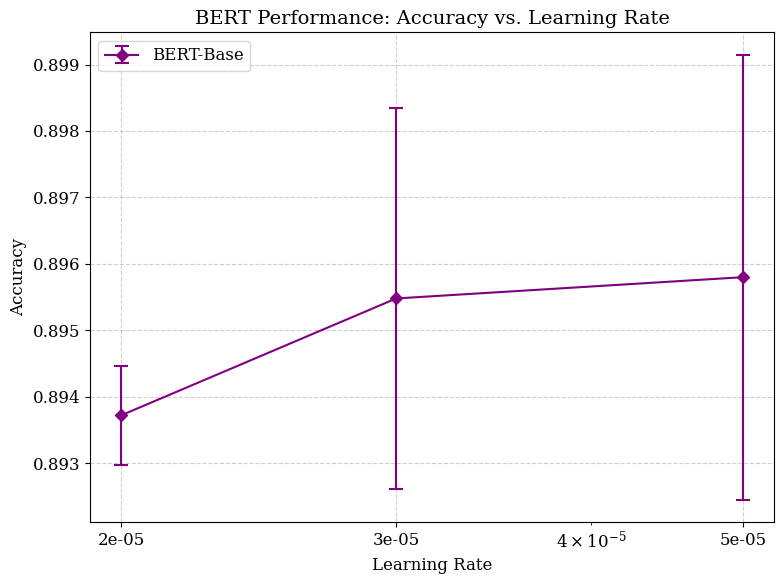

✅ BERT 图表已保存为: bert_results.pdf


In [ ]:
# === CELL 6: BERT (Full Code including Tokenization) ===
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import time

# --- A. BERT Tokenization (这一部分是之前略过的) ---
print("1. Loading BERT Tokenizer & Processing Data...")

# 加载预训练的 Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def encode_bert(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # 添加 '[CLS]' 和 '[SEP]'
            max_length=max_len,         # 截断或填充的最大长度
            padding='max_length',
            truncation=True,
            return_attention_mask=True, # 返回 attention mask
            return_tensors='pt'         # 返回 PyTorch tensors
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # 将列表转换为 Tensor
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)

# 转换训练集和验证集
# max_len=128 是为了节省显存和加快速度，对于情感分析通常够用了
train_dataset = encode_bert(X_train, y_train, max_len=128)
val_dataset = encode_bert(X_val, y_val, max_len=128)

# 创建 DataLoaders
batch_size = 32
train_dl = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dl = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

print(f"   Data ready! Train batches: {len(train_dl)}, Val batches: {len(val_dl)}")


# --- B. 训练函数 (Training Function) ---
def train_bert(lr, epochs=2):
    # 每次调用都重新初始化模型，保证 Trial 之间独立
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device) # 移动到 GPU

    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

    # Learning Rate Scheduler (Linear Warmup)
    total_steps = len(train_dl) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training Loop
    for _ in range(epochs):
        model.train()
        for batch in train_dl:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()

            # 梯度裁剪 (防止梯度爆炸)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

    # Validation Loop
    model.eval()
    preds = []
    targets = []

    for batch in val_dl:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        # 获取预测类别 (0 或 1)
        batch_preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
        preds.extend(batch_preds)
        targets.extend(b_labels.cpu().numpy())

    return accuracy_score(targets, preds), f1_score(targets, preds)


# --- C. 实验主循环 (Experiment Loop) ---
lrs = [2e-5, 3e-5, 5e-5] # 论文中指定的三个学习率
bert_results = [] # 详细结果
plot_means = []; plot_stds = [] # 绘图数据

print("\n2. Running BERT Experiments (This is the slowest part)...")
print(f"{'LR':<8} | {'Trial':<5} | {'Acc':<10} | {'F1':<10} | {'Status'}")
print("-" * 60)

for lr in lrs:
    trial_accs = []
    trial_f1s = []

    # 5 次重复实验
    for t in range(N_TRIALS):
        start_t = time.time()
        acc, f1 = train_bert(lr, epochs=2) # 固定跑 2 个 Epoch

        trial_accs.append(acc)
        trial_f1s.append(f1)

        elapsed = time.time() - start_t
        print(f"{lr:<8} | {t+1}/{N_TRIALS} | {acc:.4f}     | {f1:.4f}     | Done ({elapsed:.0f}s)")

    mean_acc = np.mean(trial_accs)
    std_acc = np.std(trial_accs)
    mean_f1 = np.mean(trial_f1s)
    std_f1 = np.std(trial_f1s)

    print("-" * 60)
    print(f"SUMMARY | LR={lr} | Mean Acc: {mean_acc:.4f} (+/- {std_acc:.4f})")
    print("-" * 60)

    bert_results.append({
        'lr': lr,
        'mean_acc': mean_acc, 'std_acc': std_acc,
        'mean_f1': mean_f1, 'std_f1': std_f1
    })

    plot_means.append(mean_acc)
    plot_stds.append(std_acc)


# --- D. 绘图 (Plotting) ---
print("\n3. Plotting Results...")
plt.figure(figsize=(8, 6))

# 计算 95% CI
yerr = [2.776 * (s / np.sqrt(N_TRIALS)) for s in plot_stds]

plt.errorbar(lrs, plot_means, yerr=yerr,
             label='BERT-Base', color='purple',
             marker='D', capsize=5, capthick=1.5)

plt.title('BERT Performance: Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log') # 学习率用对数坐标显示更清晰
plt.xticks(lrs, [str(lr) for lr in lrs]) # 强制显示横坐标数值
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

filename = 'bert_results.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()
print(f"✅ BERT 图表已保存为: {filename}")

In [ ]:
# === CELL 7: Generate LaTeX Table Data ===
print("\n=== LaTeX Table Rows (Copy into your report) ===")
def fmt(m, s): return f"${m*100:.2f} \pm {calc_ci(s)*100:.2f}$"

print("% Format: Parameter & Accuracy & F1-Score \\\\")

print("% --- Naive Bayes ---")
for r in nb_results:
    print(f"NB (Alpha={r['alpha']}) & {fmt(r['mean_acc'], r['std_acc'])} & {fmt(r['mean_f1'], r['std_f1'])} \\\\")

print("% --- kNN ---")
for metric in knn_results:
    for r in knn_results[metric]:
        print(f"kNN ({metric}, k={r['k']}) & {fmt(r['mean_acc'], r['std_acc'])} & {fmt(r['mean_f1'], r['std_f1'])} \\\\")

print("% --- SVM ---")
for kernel in svm_results:
    for r in svm_results[kernel]:
        print(f"SVM ({kernel}, C={r['C']}) & {fmt(r['mean_acc'], r['std_acc'])} & {fmt(r['mean_f1'], r['std_f1'])} \\\\")

print("% --- LSTM ---")
for r in lstm_results:
    print(f"LSTM (H={r['hidden']}, D={r['dropout']}) & {fmt(r['mean_acc'], r['std_acc'])} & {fmt(r['mean_f1'], r['std_f1'])} \\\\")

print("% --- BERT ---")
for r in bert_results:
    print(f"BERT (LR={r['lr']}) & {fmt(r['mean_acc'], r['std_acc'])} & {fmt(r['mean_f1'], r['std_f1'])} \\\\")


=== LaTeX Table Rows (Copy into your report) ===
% Format: Parameter & Accuracy & F1-Score \\
% --- Naive Bayes ---
NB (Alpha=0.1) & $84.94 \pm 0.00$ & $84.87 \pm 0.00$ \\
NB (Alpha=0.5) & $84.90 \pm 0.00$ & $84.82 \pm 0.00$ \\
NB (Alpha=1.0) & $84.94 \pm 0.00$ & $84.83 \pm 0.00$ \\
NB (Alpha=2.0) & $85.04 \pm 0.00$ & $84.91 \pm 0.00$ \\
NB (Alpha=5.0) & $85.14 \pm 0.00$ & $84.95 \pm 0.00$ \\
NB (Alpha=10.0) & $85.14 \pm 0.00$ & $84.83 \pm 0.00$ \\
% --- kNN ---
kNN (euclidean, k=1) & $69.34 \pm 0.00$ & $70.42 \pm 0.00$ \\
kNN (euclidean, k=3) & $71.72 \pm 0.00$ & $72.89 \pm 0.00$ \\
kNN (euclidean, k=5) & $72.70 \pm 0.00$ & $73.72 \pm 0.00$ \\
kNN (euclidean, k=10) & $74.28 \pm 0.00$ & $73.11 \pm 0.00$ \\
kNN (euclidean, k=15) & $74.72 \pm 0.00$ & $74.72 \pm 0.00$ \\
kNN (euclidean, k=25) & $75.72 \pm 0.00$ & $75.23 \pm 0.00$ \\
kNN (euclidean, k=50) & $76.56 \pm 0.00$ & $75.06 \pm 0.00$ \\
kNN (cosine, k=1) & $69.34 \pm 0.00$ & $70.42 \pm 0.00$ \\
kNN (cosine, k=3) & $71.72 \pm 0.00

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2009135788.py:3: SyntaxWarning: invalid escape sequence '\p'
  def fmt(m, s): return f"${m*100:.2f} \pm {calc_ci(s)*100:.2f}$"


In [ ]:
# === CELL 8: Final Evaluation on Test Set (Complete Version) ===
from sklearn.neighbors import KNeighborsClassifier # 确保导入 kNN

print("\n🏆 FINAL SHOWDOWN: Evaluating Best Models on the Held-out Test Set 🏆")
print("-" * 85)
print(f"{'Model':<15} | {'Config':<20} | {'Test Accuracy':<15} | {'Test F1-Score':<15}")
print("-" * 85)

# --- 1. 数据准备 (Data Prep) ---
# 必须使用之前 Cell 2 训练好的 tfidf 对象来转换测试集
X_test_tfidf = tfidf.transform(X_test)
# LSTM 数据准备
X_test_seq = tokenize_lstm(X_test, word_to_int)
test_final_dl = DataLoader(TensorDataset(torch.from_numpy(X_test_seq), torch.from_numpy(y_test)), shuffle=False, batch_size=32)
# BERT 数据准备
test_data_bert = encode_bert(X_test, y_test)
test_loader_bert = DataLoader(test_data_bert, sampler=SequentialSampler(test_data_bert), batch_size=32)

# --- 2. Naive Bayes ---
# (Alpha=5.0 based on your graph)
nb_final = MultinomialNB(alpha=5.0)
nb_final.fit(X_train_tfidf, y_train)
y_pred = nb_final.predict(X_test_tfidf)
print(f"{'Naive Bayes':<15} | {'Alpha=5.0':<20} | {accuracy_score(y_test, y_pred):.4f}          | {f1_score(y_test, y_pred):.4f}")

# --- 3. kNN (MISSING PIECE ADDED) ---
# (k=50, metric='cosine' based on your graph)
knn_final = KNeighborsClassifier(n_neighbors=50, metric='cosine', n_jobs=-1)
knn_final.fit(X_train_tfidf, y_train)
y_pred = knn_final.predict(X_test_tfidf)
print(f"{'kNN':<15} | {'k=50, Cosine':<20} | {accuracy_score(y_test, y_pred):.4f}          | {f1_score(y_test, y_pred):.4f}")

# --- 4. SVM ---
# (C=10, RBF based on your graph)
svm_final = SVC(kernel='rbf', C=10, gamma='scale')
svm_final.fit(X_train_tfidf, y_train)
y_pred = svm_final.predict(X_test_tfidf)
print(f"{'SVM (RBF)':<15} | {'C=10':<20} | {accuracy_score(y_test, y_pred):.4f}          | {f1_score(y_test, y_pred):.4f}")

# --- 5. LSTM ---
# (H=256, D=0.5 based on your graph)
# 重新准备训练 Loader
train_final_dl = DataLoader(TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train)), shuffle=True, batch_size=32)

def eval_lstm_final(h, d):
    model = LSTMClassifier(len(word_to_int), 100, h, d).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.BCEWithLogitsLoss()
    for _ in range(8): # Train 8 epochs
        model.train()
        for x, y in train_final_dl:
            x, y = x.to(device), y.to(device).float()
            opt.zero_grad(); crit(model(x).squeeze(), y).backward(); opt.step()
    model.eval(); preds=[]; tars=[]
    with torch.no_grad():
        for x, y in test_final_dl:
            x, y = x.to(device), y.to(device).float()
            preds.extend((model(x).squeeze()>0).float().cpu().numpy()); tars.extend(y.cpu().numpy())
    return accuracy_score(tars, preds), f1_score(tars, preds)

l_acc, l_f1 = eval_lstm_final(256, 0.5)
print(f"{'LSTM':<15} | {'H=256, D=0.5':<20} | {l_acc:.4f}          | {l_f1:.4f}")

# --- 6. BERT ---
# (LR=5e-5 based on your graph)
def eval_bert_final(lr):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
    opt = AdamW(model.parameters(), lr=lr, eps=1e-8)
    sch = get_linear_schedule_with_warmup(opt, 0, len(train_dl)*2)
    for _ in range(2): # Train 2 epochs
        model.train()
        for b in train_dl:
            model.zero_grad(); model(b[0].to(device), attention_mask=b[1].to(device), labels=b[2].to(device)).loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step(); sch.step()
    model.eval(); preds=[]; tars=[]
    for b in test_loader_bert:
        with torch.no_grad(): out=model(b[0].to(device), attention_mask=b[1].to(device))
        preds.extend(torch.argmax(out.logits,1).cpu().numpy()); tars.extend(b[2].cpu().numpy())
    return accuracy_score(tars, preds), f1_score(tars, preds)

b_acc, b_f1 = eval_bert_final(5e-5)
print(f"{'BERT':<15} | {'LR=5e-5':<20} | {b_acc:.4f}          | {b_f1:.4f}")
print("-" * 85)


🏆 FINAL SHOWDOWN: Evaluating Best Models on the Held-out Test Set 🏆
-------------------------------------------------------------------------------------
Model           | Config               | Test Accuracy   | Test F1-Score  
-------------------------------------------------------------------------------------
Naive Bayes     | Alpha=5.0            | 0.8510          | 0.8511
kNN             | k=50, Cosine         | 0.7570          | 0.7431
SVM (RBF)       | C=10                 | 0.8892          | 0.8900
LSTM            | H=256, D=0.5         | 0.8520          | 0.8509


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT            | LR=5e-5              | 0.8998          | 0.9005
-------------------------------------------------------------------------------------
